# Loading and merging the datasets:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df1 = pd.read_csv('data/RNAseqHarm/dfxROSMAP.csv') 
df2 = pd.read_csv('data/RNAseqHarm/dfxMSBB.csv') 
df3 = pd.read_csv('data/RNAseqHarm/dfxMAYO.csv') 

In [3]:
print(df1['HasAlzheimer'].value_counts())
print(df2['HasAlzheimer'].value_counts())
print(df3['HasAlzheimer'].value_counts())

1.0    984
0.0    834
Name: HasAlzheimer, dtype: int64
0.0    163
1.0     87
Name: HasAlzheimer, dtype: int64
1    80
0    67
Name: HasAlzheimer, dtype: int64


In [5]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(1818, 18866)
(250, 22744)
(147, 19443)


In [6]:
# here i want to scale each dataset individually before merging
# this is because there are differences in the residual counts
# these differences could have arisen from slight altercations in the methodology in each RNA seq study
# regardless of how they arose, it is best to scale them prior to merging them together

# getting lists of numerical columns
numerical_cols_df1 = df1.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols_df2 = df2.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols_df3 = df3.select_dtypes(include=[np.number]).columns.tolist()

# removing 'msex', 'sex', and 'HasAlzheimers' from numerical columns list
for cols in [numerical_cols_df1, numerical_cols_df2, numerical_cols_df3]:
    if 'sex' in cols: cols.remove('sex')
    if 'msex' in cols: cols.remove('msex')
    if 'HasAlzheimer' in cols: cols.remove('HasAlzheimer')


scaler = StandardScaler()

# standardize each dataframe before merging
for df, numerical_cols in zip([df1, df2, df3], [numerical_cols_df1, numerical_cols_df2, numerical_cols_df3]):
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [5]:
print(df1['HasAlzheimer'].value_counts())
print(df2['HasAlzheimer'].value_counts())
print(df3['HasAlzheimer'].value_counts())

1.0    984
0.0    834
Name: HasAlzheimer, dtype: int64
0.0    163
1.0     87
Name: HasAlzheimer, dtype: int64
1    80
0    67
Name: HasAlzheimer, dtype: int64


In [6]:
# this brings all the dataframes together into one dataframe
# basically adds several rows
# some of the genes found in one study might not be found in another study via RNA seq (creates nulls)
dfz = pd.concat([df1, df2, df3])

In [7]:
# want sex to be one column
dfz = dfz.rename(columns={'msex':'sex1'})
dfz = dfz.rename(columns={'sex':'sex2'})

In [8]:
dfz.columns
# here we see that there are around 24400 different genes in total accross the three studies
# however, we want to model on only those that are found across all three studies

Index(['specimenID', 'tissue', 'sex1', 'apoe_genotype', 'cogdx',
       'HasAlzheimer', 'ID', 'ENSG00000000003', 'ENSG00000000419',
       'ENSG00000000457',
       ...
       'ENSG00000287898', 'ENSG00000287908', 'ENSG00000287963',
       'ENSG00000287975', 'ENSG00000287981', 'ENSG00000287996',
       'ENSG00000288002', 'ENSG00000288060', 'ENSG00000288067',
       'ENSG00000288096'],
      dtype='object', length=24407)

In [9]:
dfz['HasAlzheimer'].value_counts()
# fairly balanced dataset

1.0    1151
0.0    1064
Name: HasAlzheimer, dtype: int64

In [10]:
sex_columns = dfz.filter(like='sex', axis=1)
print(sex_columns)
# need to fillna this

     sex1  sex2
0     1.0   NaN
1     0.0   NaN
2     0.0   NaN
3     0.0   NaN
4     1.0   NaN
..    ...   ...
142   NaN   1.0
143   NaN   0.0
144   NaN   0.0
145   NaN   0.0
146   NaN   1.0

[2215 rows x 2 columns]


In [11]:
dfz['sex'] = dfz['sex2'].fillna(dfz['sex1'])

In [12]:
dfe = dfz[['sex','specimenID', 'tissue', 'sex1', 'apoe_genotype', 'cogdx',
       'HasAlzheimer', 'ID']]

In [13]:
dfe.info()
# here we can see sex is filled out (now has 2215 non null values)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2215 entries, 0 to 146
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            2215 non-null   float64
 1   specimenID     2215 non-null   object 
 2   tissue         2215 non-null   object 
 3   sex1           1818 non-null   float64
 4   apoe_genotype  1818 non-null   float64
 5   cogdx          1818 non-null   float64
 6   HasAlzheimer   2215 non-null   float64
 7   ID             2215 non-null   object 
dtypes: float64(5), object(3)
memory usage: 155.7+ KB


In [14]:
dfz = dfz.dropna(axis=1, how='any')

In [15]:
dfz
# need to look at example values to understand what we are modeling on

specimenID                          tissue  HasAlzheimer          ID  \
0    492_120515  dorsolateral prefrontal cortex           1.0  492_120515   
1     02_120405  dorsolateral prefrontal cortex           1.0   02_120405   
2     03_120405  dorsolateral prefrontal cortex           0.0   03_120405   
3     04_120405  dorsolateral prefrontal cortex           0.0   04_120405   
4     07_120410  dorsolateral prefrontal cortex           0.0   07_120410   
..          ...                             ...           ...         ...   
142     962_TCX                 temporal cortex           1.0     962_TCX   
143     966_TCX                 temporal cortex           1.0     966_TCX   
144     976_TCX                 temporal cortex           1.0     976_TCX   
145     981_TCX                 temporal cortex           1.0     981_TCX   
146     991_TCX                 temporal cortex           1.0     991_TCX   

     ENSG00000000003  ENSG00000000419  ENSG00000000457  ENSG00000000460  \
0          -0.822823        -0.261834         0.367039        -0.232735   
1          -1.538932         1.038598         0.875586         0.729761   
2          -1.805362         0.012117         1.718396         0.232539   
3          -0.231795         0.883396         0.722880         1.551037   
4          -1.931548         0.113907        -0.014981        -3.650395   
..               ...              ...              ...              ...   
142         1.551550        -0.212339         0.165679        -0.167573   
143        -0.457181        -1.781207        -1.456882         0.028861   
144         2.754500        -0.691395         1.575576         0.847431   
145        -0.274543         0.478340         0.796120        -0.027985   
146         0.572510         0.186666        -0.791994        -0.815521   

     ENSG00000000938  ENSG00000000971  ...  ENSG00000287985  ENSG00000288011  \
0          -0.484354        -1.517556  ...         0.378728        -0.077814   
1          -1.043952        -1.278828  ...         0.931840         0.509776   
2          -1.410122        -2.519731  ...         1.465388         1.123928   
3          -0.635919        -0.513086  ...        -0.857878        -0.030459   
4          -0.723660        -1.534571  ...         0.544473        -0.228896   
..               ...              ...  ...              ...              ...   
142         1.369746         0.734537  ...        -0.920832        -0.014401   
143        -0.429900         0.568629  ...        -0.513216        -0.498932   
144         1.230963         1.882273  ...        -0.668166        -2.145474   
145         0.063869         0.981759  ...         0.429157         0.256060   
146        -0.130192         1.079416  ...        -0.835489         0.392763   

     ENSG00000288025  ENSG00000288033  ENSG00000288048  ENSG00000288049  \
0          -0.093656        -0.155878        -0.709228         1.344450   
1           0.541692        -0.540544        -1.586965        -0.655504   
2           0.934536         0.684749        -0.446145        -0.478101   
3           0.549490         0.257154        -0.660144        -0.611364   
4           0.752026         0.703766        -0.249193         1.402110   
..               ...              ...              ...              ...   
142        -1.342048         0.858057         2.418558         0.866873   
143         0.472148         0.601693        -1.466642        -0.898074   
144         0.230940         0.320076         1.082158        -0.598372   
145        -0.257013         0.451900        -1.130322        -0.919928   
146        -0.906683        -0.992459         0.357440         0.948046   

     ENSG00000288062  ENSG00000288075  ENSG00000288107  sex  
0           0.319615         1.253366         0.058202  1.0  
1           0.760866         0.604549        -0.151682  0.0  
2           2.029803        -0.347486         1.604083  0.0  
3          -0.077065        -1.024751        -0.221365  0.0  
4      

# Dimensionality Exploration

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras import models
from keras import layers
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import Dropout
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from umap import UMAP
import seaborn as sns

/opt/homebrew/Caskroom/miniforge/base/envs/tooters/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniforge/base/envs/tooters/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniforge/base/en

In [18]:
X = dfz.drop(['specimenID', 'HasAlzheimer','ID'], axis=1)  
y = dfz['HasAlzheimer']

categorical_cols = ['tissue'] 

numerical_cols = [col for col in X.columns if col not in categorical_cols]

In [19]:
not_floats = X.dtypes[~((X.dtypes == 'float64') | (X.dtypes == 'float32'))]
print(not_floats)


tissue    object
dtype: object


In [20]:
# preprocessing for numerical data (might be a little redundant, it is but safe to do)
numerical_transformer = StandardScaler()

# preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Let's take a look at our dimensionality

In [21]:
X_train_preprocessed = preprocessor.fit_transform(X_train)

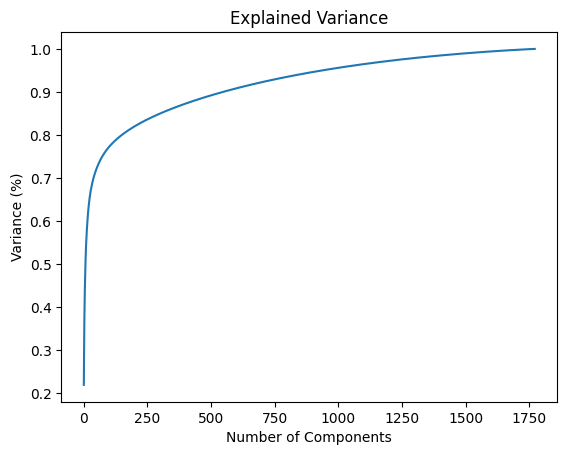

In [22]:
# fit PCA on your preprocessed data
pca = PCA().fit(X_train_preprocessed)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()


# although it takes a lot of features to explain our data, it is significantly less than the 18k
# this indicates that most genes are not relevant to alzheimers
# and it indicates that

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/1325340069.py:14: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

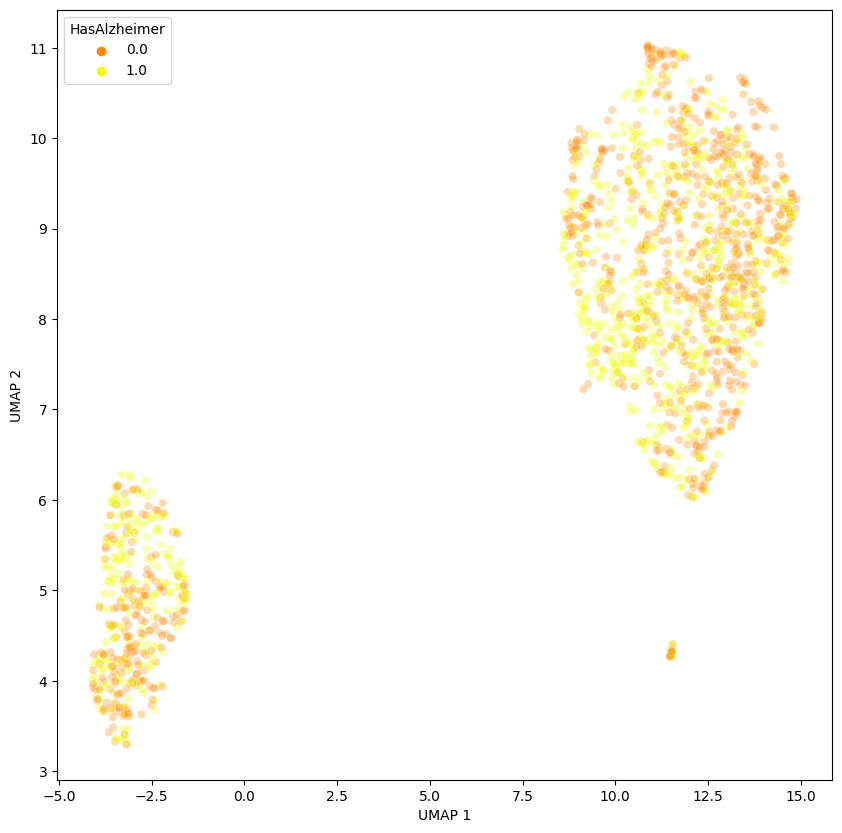

In [23]:
# UMAP
umap = UMAP(n_components=2).fit_transform(preprocessor.transform(X_train))

umap_df = pd.DataFrame(data = umap, columns = ['UMAP 1', 'UMAP 2'])
target_df = y_train.reset_index(drop=True)
umap_df = pd.concat([umap_df, target_df], axis=1)

# scatterplot
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="UMAP 1", y="UMAP 2",
    hue="HasAlzheimer",
    palette=sns.color_palette("hsv", 10),
    data=umap_df,
    legend="full",
    alpha=0.3)

# this is hard to interpret but it seems like there are two distinct groups in our dataset
# one of these groups is smaller than the other


# Now on to modeling!

In [46]:
# this was our best model (from other notebook) so we will stick to it for all our exploration

model2 = LogisticRegression(max_iter=1000)

pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', model2)
                       ])


In [47]:
pipe2.fit(X_train, y_train)
y_pred2 = pipe2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.13%


In [24]:
print(classification_report(y_test, y_pred2))

print(confusion_matrix(y_test, y_pred2))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86       204
         1.0       0.88      0.88      0.88       239

    accuracy                           0.87       443
   macro avg       0.87      0.87      0.87       443
weighted avg       0.87      0.87      0.87       443

[[176  28]
 [ 29 210]]


## Model Metrics (Classification Report, Confusion Matrix, ROC_AUC)

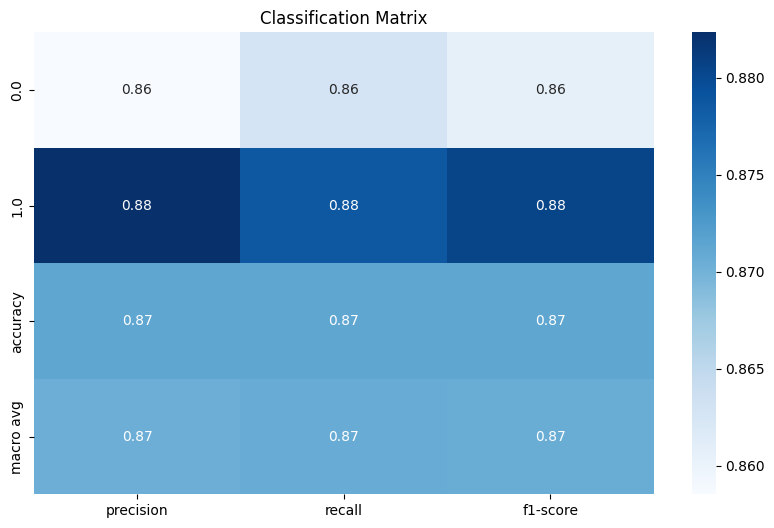

In [25]:
import seaborn as sns
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred2, output_dict=True)

report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
plt.title('Classification Matrix')
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues')
plt.show()


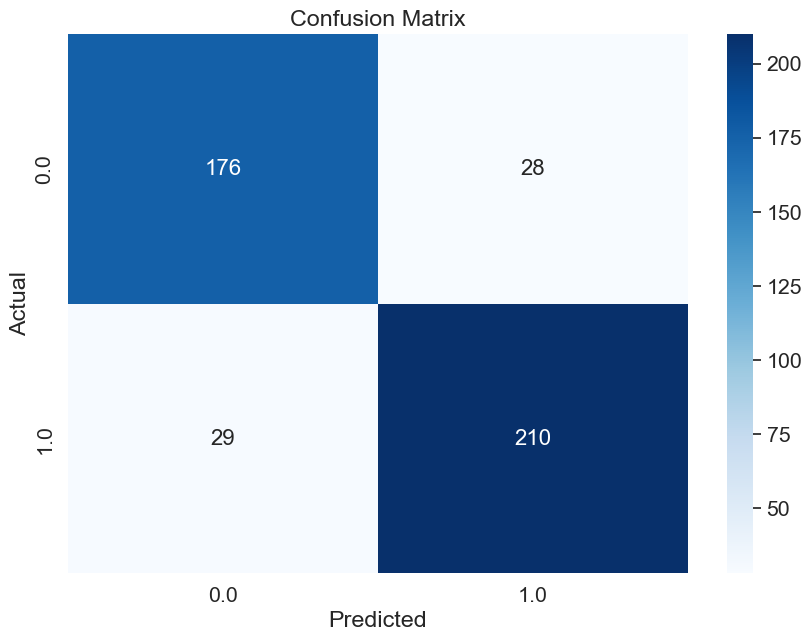

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86       204
         1.0       0.88      0.88      0.88       239

    accuracy                           0.87       443
   macro avg       0.87      0.87      0.87       443
weighted avg       0.87      0.87      0.87       443



In [26]:
from sklearn.metrics import confusion_matrix, classification_report

cnf_matrix = confusion_matrix(y_test, y_pred2)

cm_df = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_df, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='d')  # font size
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred2))


AUC: 0.93


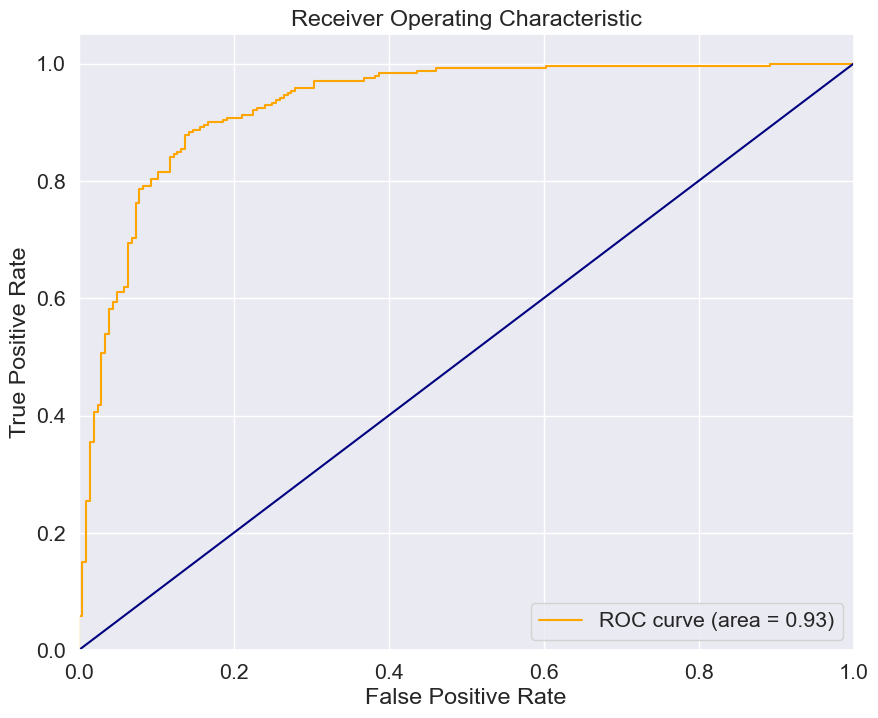

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_probs = pipe2.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"AUC: {auc_score:.2f}")

# plot the ROC curve.
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [28]:
# get the one-hot encoder from the preprocessor
onehot1 = pipe2.named_steps['preprocessor'].named_transformers_['cat']

# get the feature names after one-hot encoding
onehot_features1 = onehot1.get_feature_names_out(categorical_cols)

# list of original features
original_features1 = numerical_cols

# combine original and one-hot encoded feature names
feature_names1 = np.concatenate([original_features1, onehot_features1])

# get the coefficients from the model and make into series
coefficients1 = pipe2.named_steps['model'].coef_[0]
coef_series1 = pd.Series(coefficients1, index=feature_names1)

# sort features
sorted_features1 = coef_series1.sort_values(ascending=False)

# print the top n features
n = 50
print(sorted_features1[:n])


ENSG00000104980    0.115451
ENSG00000285799    0.113792
ENSG00000138092    0.113527
ENSG00000286613    0.110236
ENSG00000228775    0.110070
ENSG00000168743    0.107525
ENSG00000226210    0.106618
ENSG00000183688    0.104770
ENSG00000204172    0.104458
ENSG00000111788    0.103383
ENSG00000237438    0.100479
ENSG00000172661    0.099399
ENSG00000115604    0.098405
ENSG00000013573    0.096025
ENSG00000137513    0.096022
ENSG00000243678    0.095700
ENSG00000280670    0.095227
ENSG00000214652    0.094483
ENSG00000180423    0.094420
ENSG00000259845    0.092865
ENSG00000267390    0.092231
ENSG00000152778    0.092217
ENSG00000285043    0.091951
ENSG00000280099    0.091546
ENSG00000271869    0.091492
ENSG00000257800    0.090784
ENSG00000127399    0.090454
ENSG00000273188    0.089850
ENSG00000189306    0.089848
ENSG00000115602    0.089613
ENSG00000197245    0.089158
ENSG00000287706    0.088481
ENSG00000087116    0.087137
ENSG00000243107    0.086047
ENSG00000246596    0.085677
ENSG00000286261    0

In [29]:
# here we use another dataset from the study
# to change gene codes (e.g. ENSG00000104980) for better nomenclature (e.g.TIMM44)
# TIMM44 stands for Translocase Of Inner Mitochondrial Membrane 44 (name has some meaning)
ETG = pd.read_csv('data/RNAseqHarm/ROSMAP_Differential_Expression_(diagnosis-sex-age-death).tsv', delimiter="\t")

In [30]:
ETG.columns

Index(['Comparison', 'ensembl_gene_id', 'logFC', 'CI.L', 'CI.R', 'AveExpr',
       't', 'P.Value', 'adj.P.Val', 'Direction', 'hgnc_symbol',
       'percentage_gene_gc_content', 'gene_biotype', 'chromosome_name',
       'gene_length'],
      dtype='object')

In [31]:
# we just care about these two columns
ETG = ETG[['ensembl_gene_id','hgnc_symbol']]

In [32]:
ETG = ETG.drop_duplicates(subset='hgnc_symbol')

In [33]:
print(sorted_features1.head())
print(sorted_features1.tail())

ENSG00000104980    0.115451
ENSG00000285799    0.113792
ENSG00000138092    0.113527
ENSG00000286613    0.110236
ENSG00000228775    0.110070
dtype: float64
ENSG00000112619   -0.101426
ENSG00000238113   -0.101798
ENSG00000163597   -0.105098
ENSG00000204961   -0.107018
ENSG00000198712   -0.109877
dtype: float64


In [34]:
# reset the index of sorted_features before converting genes to new nomenclature
sorted_features = sorted_features1.reset_index()

In [44]:
# now we convert the features to the new nomenclature

sorted_features.columns = ['ensembl_gene_id', 'coef']
merged_df = pd.merge(sorted_features, ETG, on='ensembl_gene_id', how='left')
merged_df.set_index('hgnc_symbol', inplace=True)

# variables the top and bottom features
top_features = merged_df['coef'].head(6)
bottom_features = merged_df['coef'].tail(6)
print(top_features)
print(bottom_features)

hgnc_symbol
TIMM44        0.115451
AL645929.3    0.113792
CENPO         0.113527
AC006213.7    0.110236
WEE2-AS1      0.110070
NPNT          0.107525
Name: coef, dtype: float64
hgnc_symbol
CAPN10-DT   -0.099925
PRPH2       -0.101426
LINC01410   -0.101798
SNHG16      -0.105098
PCDHA9      -0.107018
MT-CO2      -0.109877
Name: coef, dtype: float64


In [36]:
print(top_features)
print(bottom_features)

hgnc_symbol
TIMM44        0.115451
AL645929.3    0.113792
CENPO         0.113527
AC006213.7    0.110236
WEE2-AS1      0.110070
Name: coef, dtype: float64


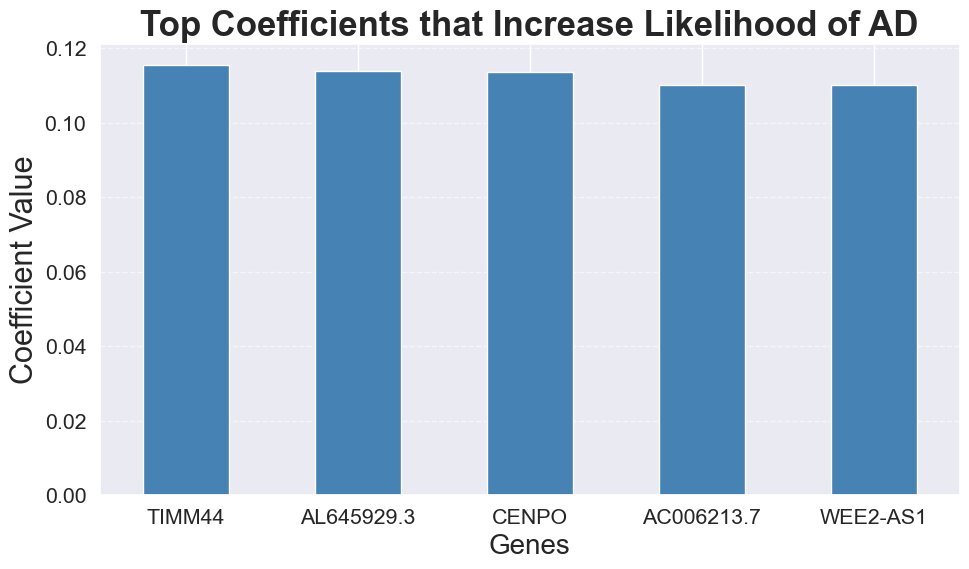

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  
top_features.plot(kind='bar', color='steelblue')  
plt.title('Top Coefficients that Increase Likelihood of AD', fontsize=25, fontweight='bold')
plt.ylabel('Coefficient Value', fontsize=22)
plt.xlabel('Genes', fontsize=20)
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.6)  
plt.tight_layout() 
plt.show()


# here is a main visualization (explored all these genes)
# wanted font to be readable from presentation slides

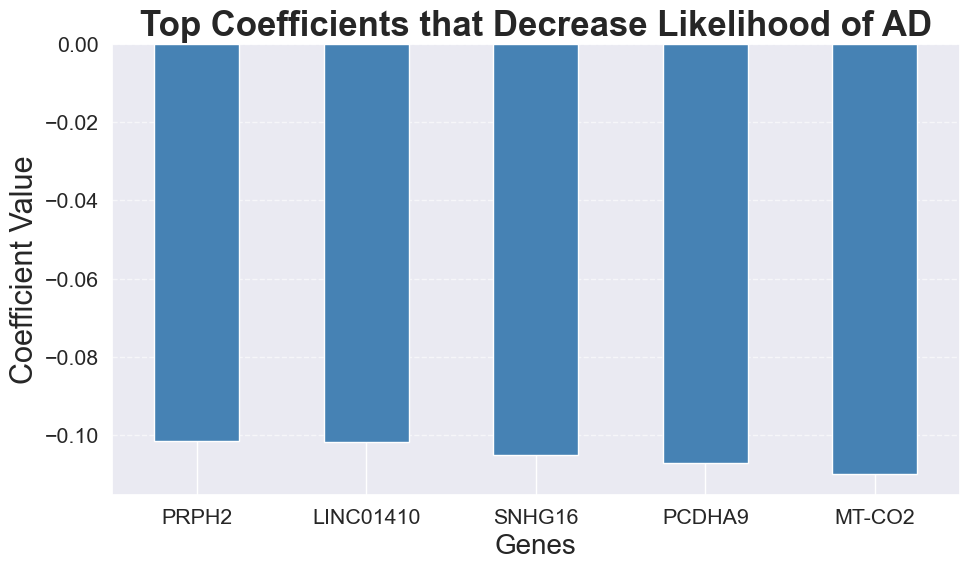

In [39]:

plt.figure(figsize=(10, 6))  
bottom_features.plot(kind='bar', color='steelblue')  
plt.title('Top Coefficients that Decrease Likelihood of AD', fontsize=25, fontweight='bold')
plt.ylabel('Coefficient Value', fontsize=22)
plt.xlabel('Genes', fontsize=20)
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.6) 
plt.tight_layout() 
plt.show()

# here is a main visualization (explored all these genes)
# wanted font to be readable from presentation slides

# Exploring Top Genes (not too informative)

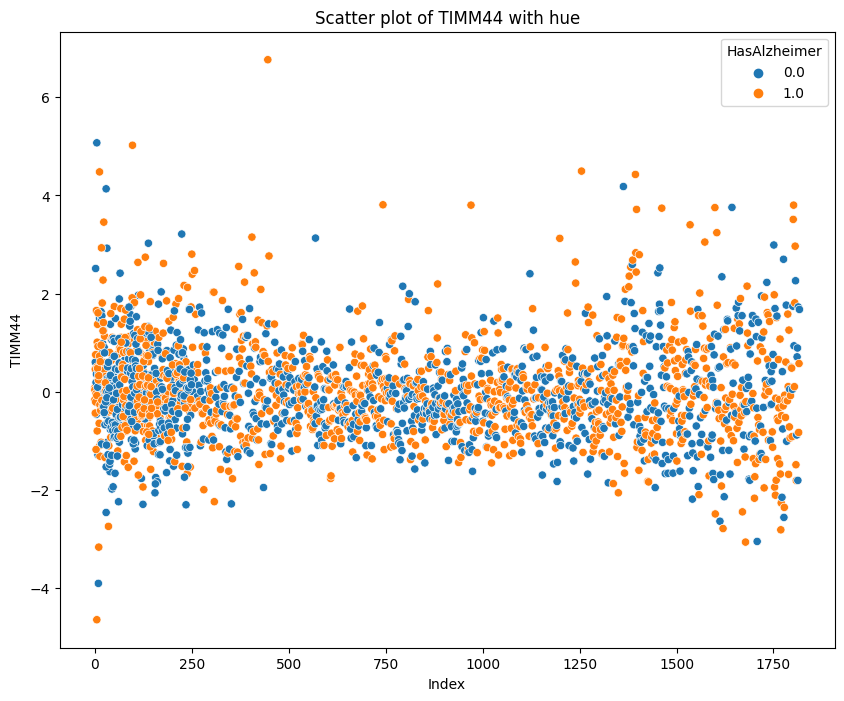

In [38]:
# looking at TIMM44 data

plt.figure(figsize=(10, 8))
sns.scatterplot(data=dfz, x=dfz.index, y='ENSG00000104980', hue='HasAlzheimer')

plt.xlabel('Index')
plt.ylabel('TIMM44')
plt.title('Scatter plot of TIMM44 with hue')
plt.show()

# nothing of significance from this visualization

In [39]:
dfa = dfz.copy()

In [40]:
dfa.isnull().sum()

specimenID         0
tissue             0
HasAlzheimer       0
ID                 0
ENSG00000000003    0
                  ..
ENSG00000288049    0
ENSG00000288062    0
ENSG00000288075    0
ENSG00000288107    0
sex                0
Length: 17007, dtype: int64

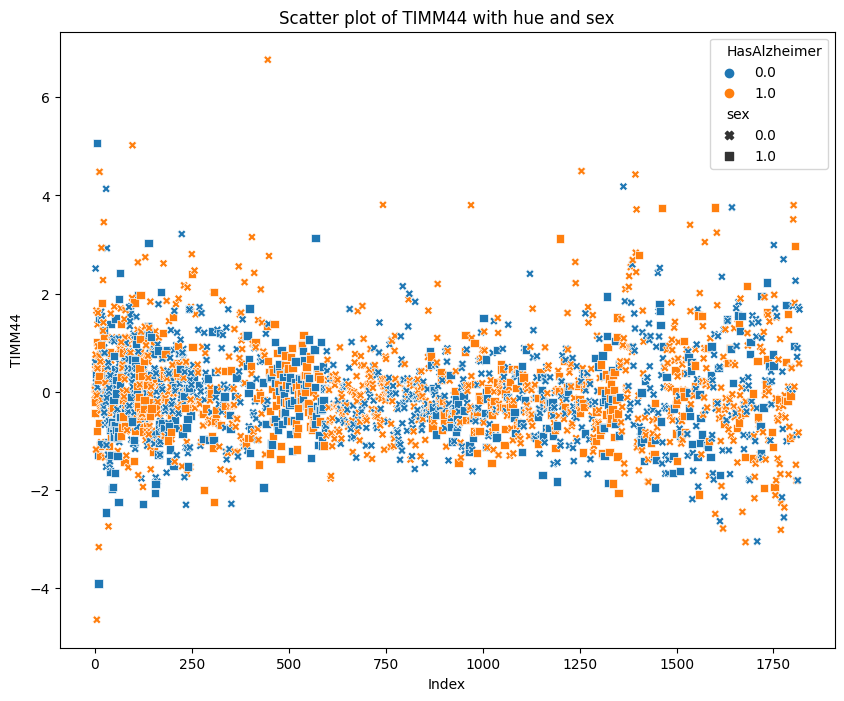

In [41]:
# dictionary to map sex to marker styles
marker_dict = {1: "s", 0: "X"}  # 's': square, 'X': x marker

plt.figure(figsize=(10, 8))
sns.scatterplot(data=dfa, x=dfa.index, y='ENSG00000104980', hue='HasAlzheimer', style=dfa['sex'], markers=marker_dict)

plt.xlabel('Index')
plt.ylabel('TIMM44')
plt.title('Scatter plot of TIMM44 with hue and sex')
plt.show()

# adding sex as a hue wasn't too insightful

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/2255596112.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dfa[dfa['HasAlzheimer'] == 0], x='ENSG00000104980', label='No Alzheimer', shade=True)
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/2255596112.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dfa[dfa['HasAlzheimer'] == 1], x='ENSG00000104980', label='Has Alzheimer', shade=True)


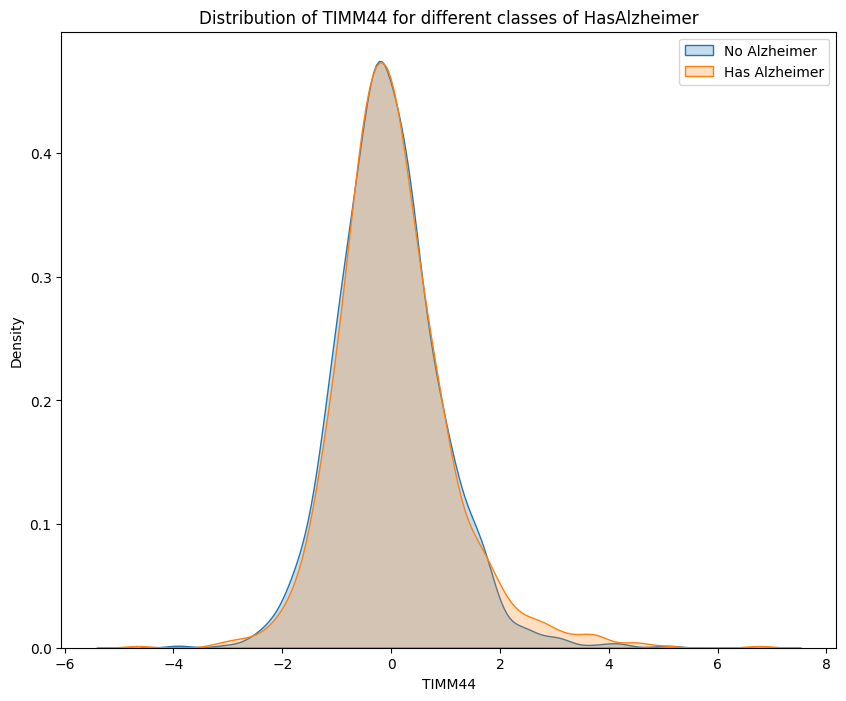

In [42]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data=dfa[dfa['HasAlzheimer'] == 0], x='ENSG00000104980', label='No Alzheimer', shade=True)
sns.kdeplot(data=dfa[dfa['HasAlzheimer'] == 1], x='ENSG00000104980', label='Has Alzheimer', shade=True)
plt.xlabel('TIMM44')
plt.title('Distribution of TIMM44 for different classes of HasAlzheimer')
plt.legend()
plt.show()

# nothing of note

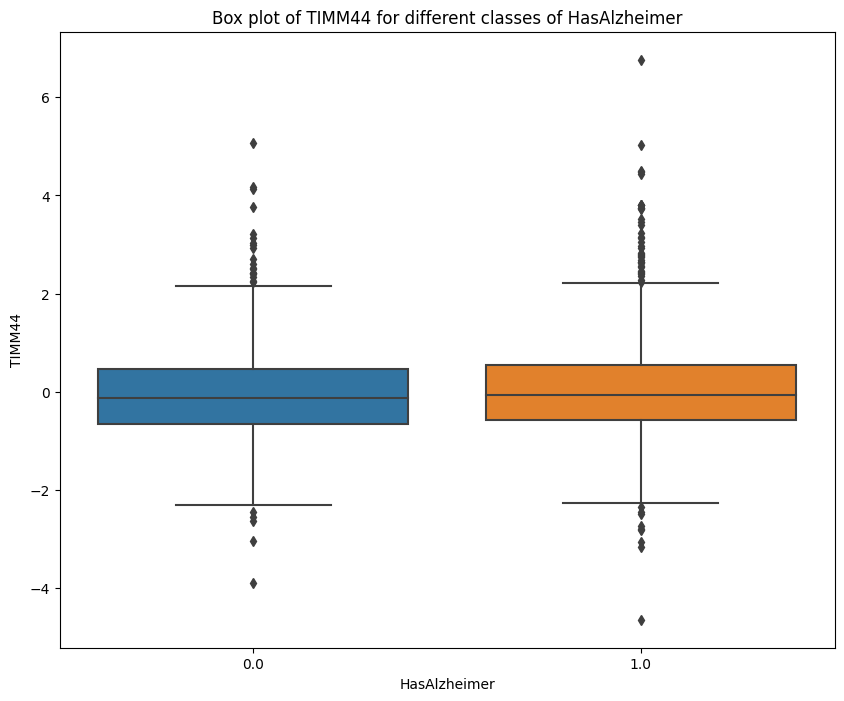

In [43]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=dfa, x='HasAlzheimer', y='ENSG00000104980')
plt.xlabel('HasAlzheimer')
plt.ylabel('TIMM44')
plt.title('Box plot of TIMM44 for different classes of HasAlzheimer')
plt.show()

# nothing of note

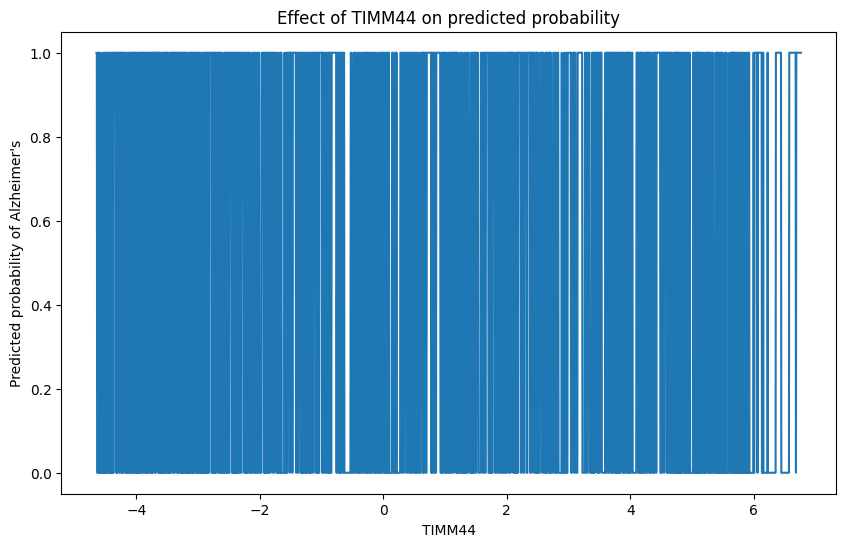

In [44]:
import statsmodels.api as sm

X_copy = X.copy()
X_copy['ENSG00000104980'] = np.linspace(X['ENSG00000104980'].min(), X['ENSG00000104980'].max(), len(X))

probs = pipe2.predict(sm.add_constant(X_copy))  

plt.figure(figsize=(10, 6))
plt.plot(X_copy['ENSG00000104980'], probs)
plt.xlabel('TIMM44')
plt.ylabel('Predicted probability of Alzheimer\'s')
plt.title('Effect of TIMM44 on predicted probability')
plt.show()

# hard to tell relationship from this

In [45]:
# range of TIMM44 values
timm44_range = np.linspace(dfz['ENSG00000104980'].min(), dfz['ENSG00000104980'].max(), num=1000)

# df with these TIMM44 values, keeping other features constant
df_predict = pd.DataFrame(data=timm44_range, columns=['ENSG00000104980'])

for column in dfz.columns:
    if dfz[column].dtype == 'object':  # for non-numerical columns
        df_predict[column] = dfz[column].mode().iloc[0]  # use mode value for non-numerical features
    elif column != 'ENSG00000104980':
        df_predict[column] = dfz[column].mean()  # use mean value for other numerical features

# predicted probabilities
probs = pipe2.predict_proba(df_predict)[:, 1]  # probabilities for class 1 (Alzheimer's)


df_predict['probability'] = probs

# average probability in different ranges of TIMM44 values
df_predict['timm44_bin'] = pd.cut(df_predict['ENSG00000104980'], bins=10)  # divide TIMM44 values into 10 equal-sized bins
average_probs = df_predict.groupby('timm44_bin')['probability'].mean()

print(average_probs)

# seems from this higher values indicate higher likelihood of alzheimers
# however this kinda doesn't make sense with previous data

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[column] = dfz[column].mean()  # use mean value for other numerical features
/var/folders/38/8tgmhx7s5t3_6pmj8rgrysmm0000gn/T/ipykernel_63356/3553864093.py:11: PerformanceWarning:

timm44_bin
(-4.659, -3.506]     0.573322
(-3.506, -2.365]     0.605131
(-2.365, -1.223]     0.636074
(-1.223, -0.0822]    0.665931
(-0.0822, 1.059]     0.694515
(1.059, 2.2]         0.721677
(2.2, 3.342]         0.747302
(3.342, 4.483]       0.771316
(4.483, 5.624]       0.793679
(5.624, 6.765]       0.814381
Name: probability, dtype: float64


In [46]:

dfz_copy = dfz.copy()

# make predictions using the original data
probs_orig = pipe2.predict_proba(X)[:, 1]  # probabilities for class 1 (Alzheimer's)

# add these probabilities to your copied DataFrame
dfz_copy['probability'] = probs_orig

# divide TIMM44 values into 10 equal-sized bins
dfz_copy['timm44_bin'] = pd.cut(dfz_copy['ENSG00000104980'], bins=10)  

# compute average probabilities in different ranges of TIMM44 values
average_probs_orig = dfz_copy.groupby('timm44_bin')['probability'].mean()

print(average_probs_orig)


timm44_bin
(-4.659, -3.506]     0.499760
(-3.506, -2.365]     0.715427
(-2.365, -1.223]     0.475152
(-1.223, -0.0822]    0.513200
(-0.0822, 1.059]     0.527086
(1.059, 2.2]         0.503166
(2.2, 3.342]         0.592929
(3.342, 4.483]       0.752089
(4.483, 5.624]       0.666422
(5.624, 6.765]       0.998804
Name: probability, dtype: float64


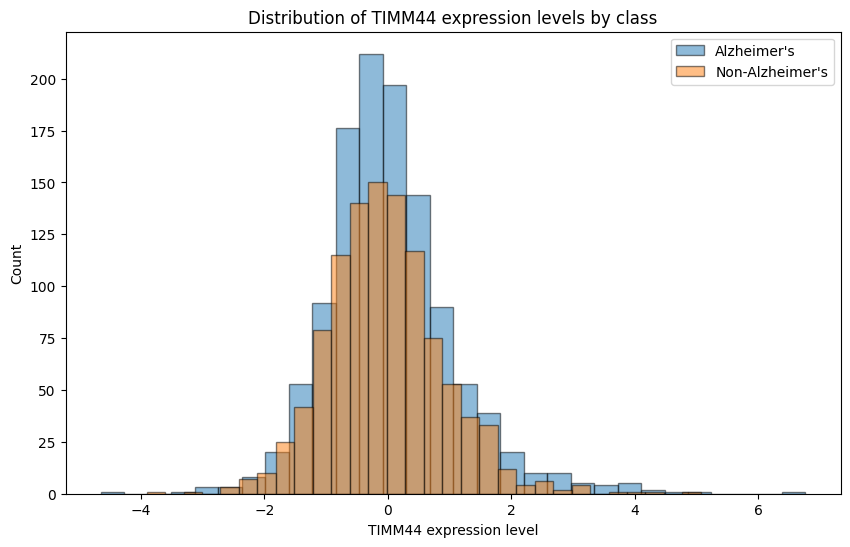

In [47]:
dfz_with_target = dfz.copy()

dfz_alz = dfz_with_target[dfz_with_target['HasAlzheimer'] == 1]
dfz_non_alz = dfz_with_target[dfz_with_target['HasAlzheimer'] == 0]

# plot histograms for both
plt.figure(figsize=(10, 6))
plt.hist(dfz_alz['ENSG00000104980'], bins=30, alpha=0.5, label='Alzheimer\'s', edgecolor='black')
plt.hist(dfz_non_alz['ENSG00000104980'], bins=30, alpha=0.5, label='Non-Alzheimer\'s', edgecolor='black')
plt.xlabel('TIMM44 expression level')
plt.ylabel('Count')
plt.title('Distribution of TIMM44 expression levels by class')
plt.legend()
plt.show()

# not too informative

In [48]:

dfz_with_target = dfz.copy()

dfz_alz = dfz_with_target[dfz_with_target['HasAlzheimer'] == 1]
dfz_non_alz = dfz_with_target[dfz_with_target['HasAlzheimer'] == 0]

# alzheimers
bins_alz = pd.cut(dfz_alz['ENSG00000104980'], bins=10)
alz_counts = dfz_alz['ENSG00000104980'].groupby(bins_alz).count()

# non alzheimers
bins_non_alz = pd.cut(dfz_non_alz['ENSG00000104980'], bins=10)
non_alz_counts = dfz_non_alz['ENSG00000104980'].groupby(bins_non_alz).count()

df_counts = pd.DataFrame({'Alzheimer\'s': alz_counts, 'Non-Alzheimer\'s': non_alz_counts})

print(df_counts)



                   Alzheimer's  Non-Alzheimer's
ENSG00000104980                                
(-4.659, -3.506]           1.0              NaN
(-3.506, -2.365]           7.0              NaN
(-2.365, -1.223]          81.0              NaN
(-1.223, -0.0822]        480.0              NaN
(-0.0822, 1.059]         431.0              NaN
(1.059, 2.2]             112.0              NaN
(2.2, 3.342]              25.0              NaN
(3.342, 4.483]            11.0              NaN
(4.483, 5.624]             2.0              NaN
(5.624, 6.765]             1.0              NaN
(-3.916, -3.009]           NaN              2.0
(-3.009, -2.111]           NaN             10.0
(-2.111, -1.213]           NaN             77.0
(-1.213, -0.315]           NaN            334.0
(-0.315, 0.583]            NaN            411.0
(0.583, 1.481]             NaN            165.0
(1.481, 2.378]             NaN             49.0
(2.378, 3.276]             NaN             12.0
(3.276, 4.174]             NaN          

In [49]:
# want to look at proportional data
total_alz = dfz_alz['ENSG00000104980'].count()
total_non_alz = dfz_non_alz['ENSG00000104980'].count()


df_prop = df_counts.copy()


df_prop['Alzheimer\'s'] = df_counts['Alzheimer\'s'] / total_alz
df_prop['Non-Alzheimer\'s'] = df_counts['Non-Alzheimer\'s'] / total_non_alz


In [50]:
print(df_prop)

                   Alzheimer's  Non-Alzheimer's
ENSG00000104980                                
(-4.659, -3.506]      0.000869              NaN
(-3.506, -2.365]      0.006082              NaN
(-2.365, -1.223]      0.070374              NaN
(-1.223, -0.0822]     0.417029              NaN
(-0.0822, 1.059]      0.374457              NaN
(1.059, 2.2]          0.097307              NaN
(2.2, 3.342]          0.021720              NaN
(3.342, 4.483]        0.009557              NaN
(4.483, 5.624]        0.001738              NaN
(5.624, 6.765]        0.000869              NaN
(-3.916, -3.009]           NaN         0.001880
(-3.009, -2.111]           NaN         0.009398
(-2.111, -1.213]           NaN         0.072368
(-1.213, -0.315]           NaN         0.313910
(-0.315, 0.583]            NaN         0.386278
(0.583, 1.481]             NaN         0.155075
(1.481, 2.378]             NaN         0.046053
(2.378, 3.276]             NaN         0.011278
(3.276, 4.174]             NaN         0

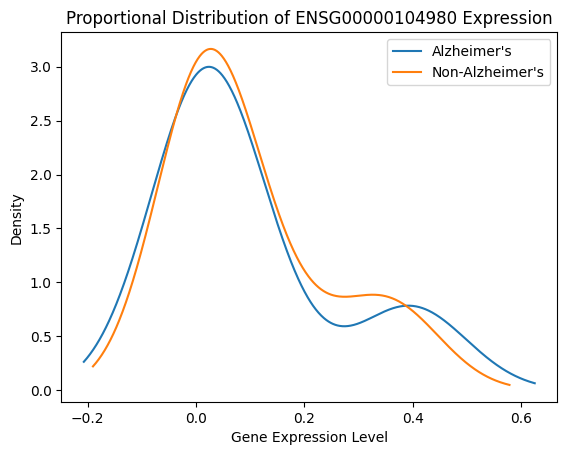

In [51]:

fig, ax = plt.subplots()


df_prop.plot(kind='density', ax=ax)


ax.set_title('Proportional Distribution of ENSG00000104980 Expression')
ax.set_xlabel('Gene Expression Level')
ax.set_ylabel('Density')

plt.show()

#not too informative

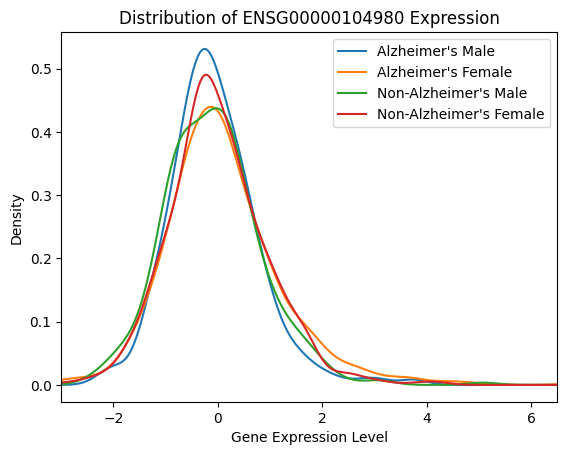

In [52]:
# want to see if it is different across sex (since we have those two umap clusters)

dfz_alz_m = dfz_with_target[(dfz_with_target['HasAlzheimer'] == 1) & (dfz_with_target['sex'] == 1)]
dfz_alz_f = dfz_with_target[(dfz_with_target['HasAlzheimer'] == 1) & (dfz_with_target['sex'] == 0)]
dfz_non_alz_m = dfz_with_target[(dfz_with_target['HasAlzheimer'] == 0) & (dfz_with_target['sex'] == 1)]
dfz_non_alz_f = dfz_with_target[(dfz_with_target['HasAlzheimer'] == 0) & (dfz_with_target['sex'] == 0)]

fig, ax = plt.subplots()

dfz_alz_m['ENSG00000104980'].plot(kind='density', ax=ax, label='Alzheimer\'s Male')
dfz_alz_f['ENSG00000104980'].plot(kind='density', ax=ax, label='Alzheimer\'s Female')
dfz_non_alz_m['ENSG00000104980'].plot(kind='density', ax=ax, label='Non-Alzheimer\'s Male')
dfz_non_alz_f['ENSG00000104980'].plot(kind='density', ax=ax, label='Non-Alzheimer\'s Female')

ax.set_title('Distribution of ENSG00000104980 Expression')
ax.set_xlabel('Gene Expression Level')
ax.set_ylabel('Density')
ax.set_xlim([-3, 6.5])

ax.legend()

plt.show()


In [53]:
#  correlations with TIMM44
correlations = dfz.corrwith(dfz['ENSG00000104980']).sort_values(ascending=False)

print(correlations)


ENSG00000104980    1.000000
ENSG00000134815    0.607400
ENSG00000160087    0.584171
ENSG00000182208    0.575606
ENSG00000104960    0.563796
                     ...   
ENSG00000112697   -0.483543
ENSG00000256043   -0.490187
ENSG00000109919   -0.491613
ENSG00000117906   -0.499024
ENSG00000138613   -0.524837
Length: 17004, dtype: float64


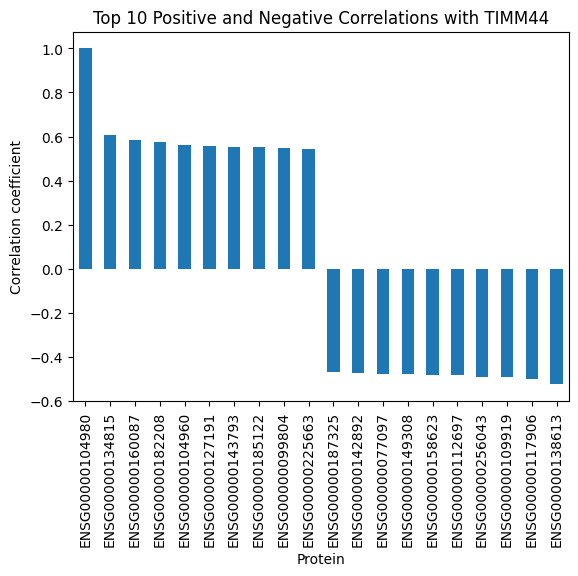

In [54]:
# top 10 positively correlated proteins
top_pos = correlations.head(10)

# top 10 negatively correlated proteins
top_neg = correlations.tail(10)

top_corr = pd.concat([top_pos, top_neg])

top_corr.plot(kind='bar')
plt.title('Top 10 Positive and Negative Correlations with TIMM44')
plt.ylabel('Correlation coefficient')
plt.xlabel('Protein')
plt.show()
